# Поиск аномалий в данных офисных товаров

## Получение и изучение данных

**Заказчик интернет-магазин офисных товаров**

В датасете содержится информация о 9994 продажах.

Ключевые признаки для поиска аномалий:
- `Sales` - продажи;
- `Profit` - прибыль.

**Цель: выявление явных аномалий для дальнейшего анализа.**

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from pyod.models.knn import KNN

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings("ignore")

### Чтение данных

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/sales.csv')

In [3]:
df[['Sales', 'Profit']].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [4]:
df[['Sales', 'Profit']].describe()

,Sales,Profit
count,9994.000000,9994.000000
mean,229.858001,28.656896
std,623.245101,234.260108
min,0.444000,-6599.978000
25%,17.280000,1.728750
50%,54.490000,8.666500
75%,209.940000,29.364000
max,22638.480000,8399.976000


- При вызове базовых методотов для изучения данных наблюдаются предполагаемые аномалии, наличие которых может негативно сказаться на машинном обучении.
- Далее проведем более детальное выявление аномалий.

## Диаграмма размаха

Построим ящик с усами для признака 'Sales' - «продажи».

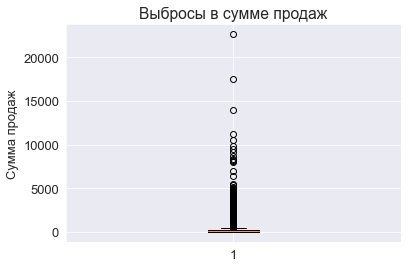

In [5]:
boxplot_sales = plt.boxplot(df['Sales'].values)
plt.ylabel('Сумма продаж')
plt.title("Выбросы в сумме продаж")
plt.show() 

- Средний чек бо́льшей части покупок — 500–1000 $.
- Продажи от 5 до 20 тысяч долларов — аномалии (они отмечены кругами).

---

Диаграмма даёт информацию обо всех выбросах. Она хранится в записи `"fliers"` (на англ. синоним «аномалии») внутри объекта *boxplot*. Вызовом функции `get_data()` из объектов получим числа. Нужные значения отделены индексами.

In [6]:
outliers_sales = list(boxplot_sales["fliers"][0].get_data()[1])
print("Выбросов в продажах: ", len(outliers_sales))

Выбросов в продажах:  1167


- Найдем в датасете аномалии по признаку `'Profit'`. Из ящика с усами возьмем список аномалий и запишем результат в переменной outliers.
- Отфильтруем исходный датафрейм и сохраним список объектов с аномалиями в переменной `df_outliers_profit`.
- Выведем количество аномалий (уже в прекоде).

Количество аномалий:  1881


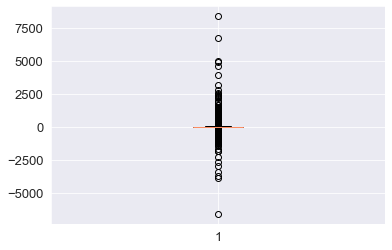

In [7]:
boxplot_profit = plt.boxplot(df['Profit'].values)
outliers_profit = list(boxplot_profit["fliers"][0].get_data()[1])
df_outliers_profit = df[df['Profit'].isin(outliers_profit)]
print("Количество аномалий: ", len(df_outliers_profit))

Почти 20% заказов - выбросы.

Перепроверим другим алгоритмом.

## Изоляционный лес

Обучим модель изоляционного леса и вычислим количество аномалий по признакам:
- продаж `df['Sales']`;
- прибыли `df['Profit']`.

Определим количество аномалий.

In [8]:
data = df[['Sales', 'Profit']]                        # объединим данные о продажах и прибыли.
 
isolation_forest = IsolationForest(n_estimators=100,  # количество деревьев в параметре n_estimators
                                   random_state=2007) # псевдослучайность 
estimator = isolation_forest.fit_predict(data)        # обучим модель и получим классификацию
outliers = list(estimator[estimator==-1])             # определим выбросы (только оценки, равные -1)

print("Количество аномалий: ", len(outliers))

Количество аномалий:  1117


- Изоляционный лес показал аномальных случаев почти в два раза меньше.

## Метод ближайших соседей (KNN)

- Моделью KNN и изоляционным лесом найдем выбросы в данных с переменными 'Sales' и 'Profit'.
- Выясним, сколько аномалий совпало.
- Напечатаем на экране два варианта количества выбросов и число совпавших аномалий.

In [9]:
model = KNN()
estimation_knn = model.fit_predict(data) == 1                 # «1» означает аномалию
outliers_knn = estimation_knn.sum() 
print("Количество аномалий (KNN): ", outliers_knn)

isolation_forest = IsolationForest(n_estimators=100)
estimation_iforest = isolation_forest.fit_predict(data) == -1 # «-1» означает аномалию
outliers_iforest =  estimation_iforest.sum()
print("Количество аномалий (изоляционный лес): ", outliers_iforest)

print("Совпало: ", (estimation_knn & estimation_iforest).sum())

Количество аномалий (KNN):  1000
Количество аномалий (изоляционный лес):  1101
Совпало:  894


Большая часть совпала - это самые явные аномалии.